In [1]:
using Plots, PyPlot, DynamicalSystems, Random, Distributions, StatsBase, DataFrames, CSV, Dates, KernelDensity, Interpolations, StatsPlots


In [26]:
# data = CSV.File(string("../../Advanced_Analytics/Dissertation/Code/MDTG-MALABM/Data/CoinTossX/L1LOBStar.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Initialization => Symbol, :Type => Symbol)) |> x -> filter(y -> y.Initialization != :INITIAL, x) |> DataFrame

date = DateTime("2019-07-08")
startTime = date + Hour(9) + Minute(1)
endTime = date + Hour(16) + Minute(50) 

data = CSV.File(string("../../Advanced_Analytics/Dissertation/Code/MDTG-MALABM/Data/JSE/L1LOB.csv"), drop = [:MidPrice, :Spread, :Price], missingstring = "missing", types = Dict(:DateTime => DateTime, :Type => Symbol)) |> DataFrame
filter!(x -> startTime <= x.DateTime && x.DateTime < endTime, data)

data.Date = Date.(data.DateTime)
uniqueDays = unique(data.Date)
uniqueDays = unique(data.Date)
logreturns = map(day -> diff(log.(skipmissing(data[searchsorted(data.Date, day), :MicroPrice]))), uniqueDays) |> x -> reduce(vcat, x)


15103-element Vector{Float64}:
  0.0002757723818032076
  0.0003667655181480711
 -0.00014582778600669144
 -0.00015005857861183358
  0.00039472731904410807
 -5.382359394090486e-5
  0.000553367785879999
 -8.564503610308805e-5
  8.10091109002542e-5
  4.3093613033562406e-6
  3.670076496931074e-6
  0.0
 -9.645426136195567e-5
  ⋮
 -8.337185779083711e-6
  0.00010939548433519519
  2.407063844245272e-5
  7.997668349446485e-5
  0.0
  4.196837880776627e-5
 -1.4061841653756346e-5
 -0.00012387336748709288
 -2.3589810197677252e-5
  4.52770184011797e-6
  1.8703157103061585e-6
  1.9056010902573917e-6

In [27]:
# bin the log returns for smoothing
function bin(logreturns, bins)
    logreturns_binned = Vector{Float64}()
    for i in bins:length(logreturns)
        start = (i-bins)+1
        push!(logreturns_binned, mean(logreturns[start:i]))
    end
    return logreturns_binned
end

bin (generic function with 1 method)

In [28]:
# remove the transient
transient = 100
logreturns_trns = logreturns[transient:end]

15004-element Vector{Float64}:
 -1.5115089622597111e-5
 -0.00018456441449998806
  0.0001418346168602369
 -2.1365583528165644e-5
 -0.0004287206811657285
  0.0004066562631290793
 -2.6075909856260182e-5
 -2.1730444300871454e-5
 -0.00011789101995240969
  5.1446791124121205e-5
 -7.116841363341564e-5
  5.442585274018086e-5
  0.0001361596522748698
  ⋮
 -8.337185779083711e-6
  0.00010939548433519519
  2.407063844245272e-5
  7.997668349446485e-5
  0.0
  4.196837880776627e-5
 -1.4061841653756346e-5
 -0.00012387336748709288
 -2.3589810197677252e-5
  4.52770184011797e-6
  1.8703157103061585e-6
  1.9056010902573917e-6

In [29]:
# bin the log returns with no transient
logreturns_binned = bin(logreturns_trns, 10)

14995-element Vector{Float64}:
 -2.1552547181258318e-5
 -2.715787958234017e-5
 -3.25885285832328e-6
 -3.826349316859989e-6
  5.634759793871069e-6
  6.987433756933115e-6
 -0.00011329622324804945
 -0.00014700459073324623
 -0.00013165047747314417
 -0.00014515603248135278
 -0.00016446951922315377
 -0.00013453734523469763
 -0.0001627952631338303
  ⋮
 -1.1402051187658913e-6
  1.2961561316515712e-5
  1.1197826852082926e-5
  1.9087675211260092e-5
  1.9211994625578655e-5
  2.333645072667423e-5
  2.41901399213873e-5
  5.242920463643941e-6
  2.809506285217367e-6
  9.007668180238682e-6
  1.0028418329177669e-5
 -7.205699953161116e-7

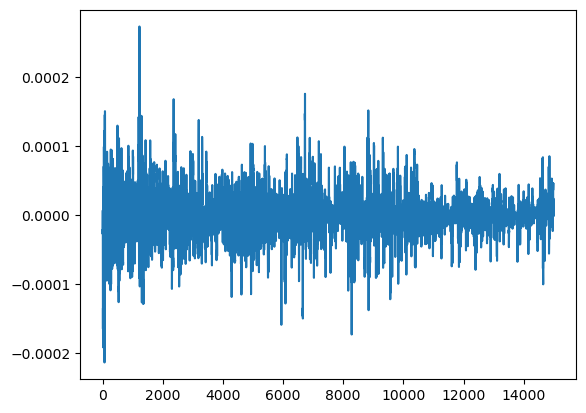

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f60b326df90>

In [30]:
# plot the binned log returns
plt.plot(logreturns_binned)


## Compute the time delay parameter

In [31]:
# set parameters
lags = 1:100

1:100

Tau: 10


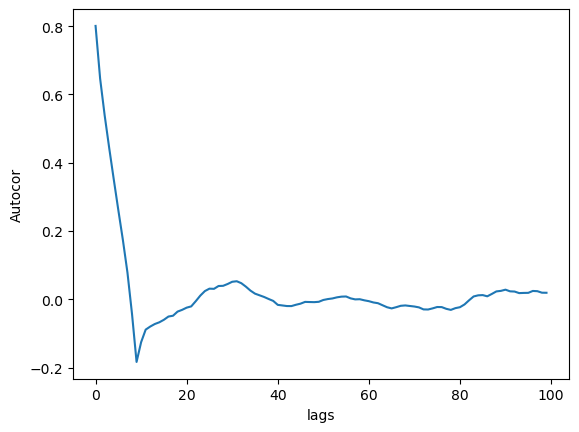

In [32]:
# compute the time delay using the autocorrelation of the micro-prices (first min since min is always 1)
return_autocor = autocor(logreturns_binned, lags)
plt.plot(return_autocor)
xlabel("lags")
ylabel("Autocor")
tau = estimate_delay(logreturns_binned, "ac_min", lags)
println("Tau: " * string(tau))


## Compute the correlation dimension (do box-counting for sanity)
Note: D2 can't exceed 2log10(N), where N is the number of data points

In [33]:
Dmax = 2 * log10(length(logreturns_binned))

8.351892940191092

In [34]:
# compute the GP correlation dimension and use m to compute the required delay dimension
function PlotCorrelationVsBoxSize(data, dims, es_starts, es_stops, es_step, tau)
    
    slopes = Vector{Float64}()
    
    subplot_dims = Int(ceil(length(dims)/3))
#     fig = plt.figure(figsize=plt.figaspect(0.5))

    for (i, dim) in enumerate(dims)
        # set box size range
        es = ℯ .^ (es_starts[i]:es_step:es_stops[i])
        es_log = log.(es)
        
        # create correlation embeddings
        recon = embed(data, dim, tau)
        cs = correlationsum(recon, es; q = 2)
        reg_res = linear_region(log.(es), log.(cs); tol = 0.8)
        slope = reg_res[2]
        push!(slopes, slope)
        
        # make plots
        plt.plot(es_log, cs, label = dim)
        plt.plot(es_log[reg_res[1][1]:reg_res[1][2]], cs[reg_res[1][1]:reg_res[1][2]])
    end
    plt.legend()
    
    return slopes
    
end

PlotCorrelationVsBoxSize (generic function with 1 method)

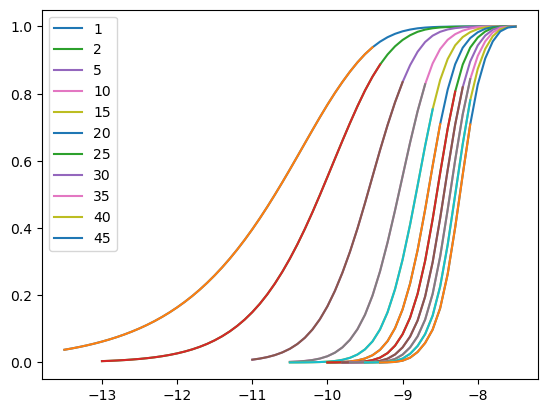

11-element Vector{Float64}:
 0.8192814270366966
 1.5138802896311472
 2.367281628317659
 3.529116188603403
 4.793033254494002
 5.100249092494736
 5.7551319704492325
 6.151113403269353
 6.4358879353983784
 6.682858995406291
 6.7527830353115

In [35]:
dims = [1,2,5,10,15,20,25,30,35,40,45] 
es_starts = [-13.5,-13,-11,-10.5,-10.5,-10,-10,-9.8,-9.7,-9.5,-9.3]
es_stops = ones(length(dims)) .* -7.5
es_step = 0.1 
tau = 10
slopes = PlotCorrelationVsBoxSize(logreturns_binned, dims, es_starts, es_stops, es_step, tau)

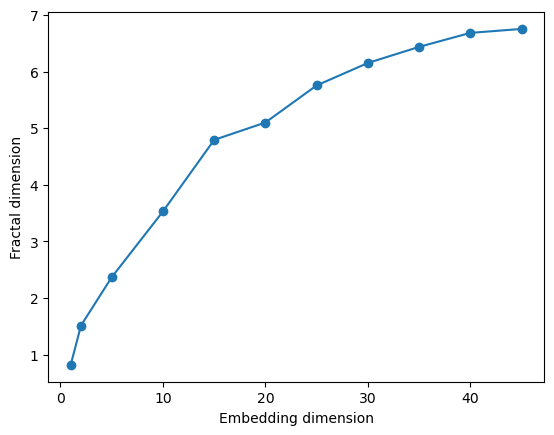

PyObject Text(24.000000000000007, 0.5, 'Fractal dimension')

In [36]:
plt.plot(dims, slopes, marker = "o")
xlabel("Embedding dimension")
ylabel("Fractal dimension")


A quick note on hyperparams:
1. Tau: If tau <= 5 then we have the the above analysis suggests the embedding dimension should be 1, however if tau > 5, (at least less than 20) we have that the embedding dim should be 2. All experiments suggest convergence and constant behaviour after about 30 embedding dimensions.
2. Increasing the binning increases tau and decreases the number of dimensions.

Also interesting to note that I tested the JSE and the fractal dimension evened out around 5 or 6.

In [13]:
# create the necessary embedding tau = firstmin(autocorrelation), dim = ceil(max_fractal)
tau = 10
dim = 2
R = embed(logreturns_binned, 2, 10)

2-dimensional Dataset{Float64} with 12073 points
  4.36344e-6  -3.25078e-5
 -3.23759e-5   2.00542e-5
 -1.49026e-5   4.14697e-5
  1.01834e-5   2.70315e-5
  8.88662e-7   4.80415e-5
 -2.19789e-5   2.94232e-5
 -6.97739e-5  -3.1741e-6
 -7.25283e-5  -5.29859e-6
 -8.50516e-5  -5.58583e-5
 -8.48558e-5  -5.39963e-5
 -3.25078e-5  -8.60856e-6
  2.00542e-5   6.82166e-6
  4.14697e-5  -1.86691e-5
  ⋮           
  3.60446e-5  -6.65643e-5
  4.08636e-5  -3.99717e-5
  4.82564e-5  -6.25329e-5
  5.27649e-5  -5.06038e-5
  5.77487e-5  -7.36902e-5
  1.47663e-5  -8.10113e-6
  4.59387e-5  -1.62825e-5
  6.24753e-6   5.15544e-5
 -3.25508e-5  -6.91195e-6
  3.8894e-5   -2.20062e-5
 -6.65643e-5   8.94701e-6
 -3.99717e-5  -2.43247e-5

In [14]:
# perform any dim reduction needed to create a visualisation of the embedding

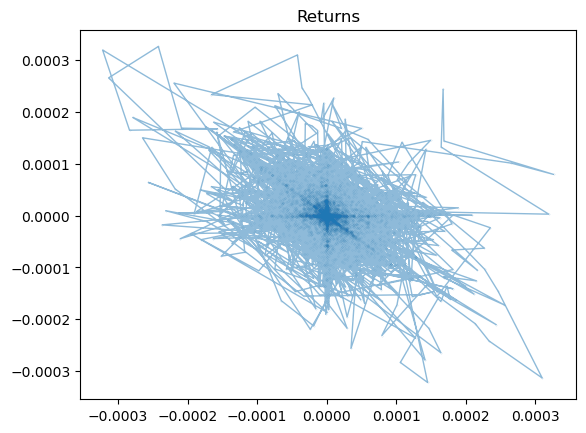

PyObject Text(0.5, 1.0, 'Returns')

In [15]:
# plot embedding
start = 1
finish = length(R)
plt.plot(R[start:finish, 1], R[start:finish, 2], lw = 1, marker = "o", ms = 0.1, alpha = 0.5)
plt.title("Returns")

## Smooth the embedding using NN

In [16]:
# can do ball or square, I will do ball first because it is easiest
function GetNeighbours(data, point, nlast, epsilon)
    neighboursX = Vector{Float64}()
    neighboursY = Vector{Float64}()
    neighboursT = Vector{Int64}()
    neigboursDists = Vector{Float64}()
    for i in 1:size(data)[1]
        # compute dist to all other point
        next_point = data[i,:]
        if next_point.t == point.t # dont compare to itself
            continue
        else
            dist = sqrt((point.x - next_point.x)^2 + (point.y - next_point.y)^2)
            if dist <= epsilon && (point.t - nlast) <= next_point.t && next_point.t < point.t # check if in ball and check if in time bound
                push!(neighboursX, next_point.x)
                push!(neighboursY, next_point.y)
                push!(neighboursT, next_point.t)
                push!(neigboursDists, dist)
            end
        end
    end
    if length(neighboursX) == 0
        neighboursX = point.x
        neighboursY = point.y
        neighboursT = point.t
        neigboursDists = 0
    end
    return neighboursX, neighboursY, neighboursT, neigboursDists
end

GetNeighbours (generic function with 1 method)

In [17]:
t,(x,y) = collect(1:length(R)), columns(R)
embedded_dataset = DataFrame(Dict("t"=>t,"x"=>x,"y"=>y))

,t,x,y
,Int64,Float64,Float64
1,1,4.36344e-6,-3.25078e-5
2,2,-3.23759e-5,2.00542e-5
3,3,-1.49026e-5,4.14697e-5
4,4,1.01834e-5,2.70315e-5
5,5,8.88662e-7,4.80415e-5
6,6,-2.19789e-5,2.94232e-5
7,7,-6.97739e-5,-3.1741e-6
8,8,-7.25283e-5,-5.29859e-6
9,9,-8.50516e-5,-5.58583e-5


In [18]:
nlast = 30
epsilon = 1e-3
GetNeighbours(embedded_dataset, embedded_dataset[1,:], nlast, epsilon)

(4.363436686993793e-6, -3.250780574575174e-5, 1, 0)

In [19]:
function NearestNeighboursSmoothing(data, nlast, epsilon)
    smoothed_vecs = Vector{Vector{Float64}}()
    for i in 1:size(data)[1]
        neighboursX, neighboursY, neighboursT, neigboursDists = GetNeighbours(data, data[i,:], nlast, epsilon)
#         mean(neighboursX[i] * 1/(neigboursDists[i]) for i in 1:length(neighboursT)), mean(neighboursY[i] * 1/(neigboursDists[i]) for i in 1:length(neighboursT))
        if i % 100 == 0
            println("I: ", i," Number of neighbours: ", length(neighboursX), " Average dist: ", mean(neigboursDists))
        end
        push!(smoothed_vecs, [mean(neighboursX), mean(neighboursY)])
    end
    return smoothed_vecs
end

NearestNeighboursSmoothing (generic function with 1 method)

In [20]:
smoothed_vecs = NearestNeighboursSmoothing(embedded_dataset, nlast, epsilon)

I: 100 Number of neighbours: 30 Average dist: 0.00014357941670950272
I: 200 Number of neighbours: 30 Average dist: 7.84453583772891e-5
I: 300 Number of neighbours: 30 Average dist: 2.4760521384136127e-6
I: 400 Number of neighbours: 30 Average dist: 2.2762143607202522e-5
I: 500 Number of neighbours: 30 Average dist: 2.1026901183801728e-5
I: 600 Number of neighbours: 30 Average dist: 3.6332289499370334e-7
I: 700 Number of neighbours: 30 Average dist: 4.054141772164808e-5
I: 800 Number of neighbours: 30 Average dist: 6.633097337273635e-5
I: 900 Number of neighbours: 30 Average dist: 4.23563528701892e-5
I: 1000 Number of neighbours: 30 Average dist: 0.00010100095824358318
I: 1100 Number of neighbours: 30 Average dist: 5.079330443934202e-5
I: 1200 Number of neighbours: 30 Average dist: 4.8781380375871465e-5
I: 1300 Number of neighbours: 30 Average dist: 5.724456329633319e-6
I: 1400 Number of neighbours: 30 Average dist: 2.6955695752091806e-5
I: 1500 Number of neighbours: 30 Average dist: 2.

12073-element Vector{Vector{Float64}}:
 [4.363436686993793e-6, -3.250780574575174e-5]
 [4.363436686993793e-6, -3.250780574575174e-5]
 [-1.4006224706886173e-5, -6.226822299559844e-6]
 [-1.4305010074503837e-5, 9.672021220078856e-6]
 [-8.182919328714179e-6, 1.4011881905728883e-5]
 [-6.368603125892492e-6, 2.0817814206921524e-5]
 [-8.970325260282408e-6, 2.2252046045867504e-5]
 [-1.7656552734303587e-5, 1.8619739778864238e-5]
 [-2.4515527085777756e-5, 1.5629948646056493e-5]
 [-3.1241762925699525e-5, 7.686808916496094e-6]
 [-3.6603171193760883e-5, 1.5184986933647364e-6]
 [-3.6230865243941874e-5, 5.978570210371287e-7]
 [-3.1540446378060714e-5, 1.1165069327005288e-6]
 ⋮
 [2.9467884308805484e-6, 1.1281306821461593e-5]
 [6.229216932460702e-6, 6.782145540409346e-6]
 [8.085373846178357e-6, 3.859565283791019e-6]
 [1.0048360052810066e-5, 3.118352066581547e-7]
 [1.3673268070479119e-5, -8.926074897175333e-7]
 [1.5574509392942317e-5, -4.3291574170526795e-6]
 [1.4710610907033107e-5, -5.103479685691544e-6]

In [21]:
# perform required dim reduction

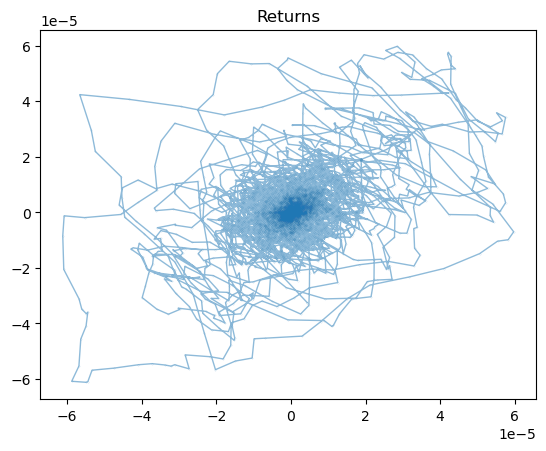

PyObject Text(0.5, 1.0, 'Returns')

In [22]:
# plot smoothed embedding
start = 1
finish = length(smoothed_vecs)
plt.plot([s for (s,j) in smoothed_vecs], [j for (s,j) in smoothed_vecs], lw = 1, marker = "o", ms = 0.1, alpha = 0.5)
plt.title("Returns")


In [23]:
x = [s for (s,j) in smoothed_vecs]
xdot = [j for (s,j) in smoothed_vecs]
# perm = sortperm(x)
# x_sort = x[perm]
# xdot_sort = xdot[perm]
# k = kde((x_sort, xdot_sort))
# ik = InterpKDE(k)
# z = pdf(ik, x_sort, xdot_sort)


12073-element Vector{Float64}:
 -3.250780574575174e-5
 -3.250780574575174e-5
 -6.226822299559844e-6
  9.672021220078856e-6
  1.4011881905728883e-5
  2.0817814206921524e-5
  2.2252046045867504e-5
  1.8619739778864238e-5
  1.5629948646056493e-5
  7.686808916496094e-6
  1.5184986933647364e-6
  5.978570210371287e-7
  1.1165069327005288e-6
  ⋮
  1.1281306821461593e-5
  6.782145540409346e-6
  3.859565283791019e-6
  3.118352066581547e-7
 -8.926074897175333e-7
 -4.3291574170526795e-6
 -5.103479685691544e-6
 -8.411420629060494e-6
 -6.412032701780628e-6
 -6.032297061603724e-6
 -5.850281763433904e-6
 -5.2880903890203025e-6

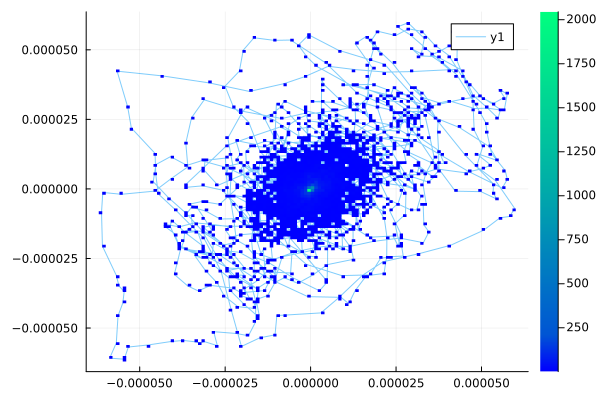

In [24]:
Plots.plot(x, xdot, linewidth = 1, alpha = 0.5)
Plots.histogram2d!(x, xdot, show_empty=false, bins = 150, c = cgrad(:winter, [0, 0.1, 0.50, 1]))


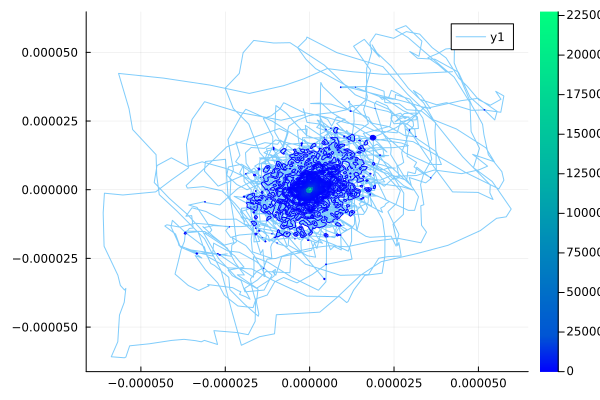

In [25]:
density = kde((x, xdot))
Plots.plot(x, xdot, linewidth = 1, alpha = 0.5)
StatsPlots.plot!(density, levels = 1500, c = cgrad(:winter, [0, 0.1, 0.50, 1]))